In [1]:
from essentia import *
from essentia.standard import Spectrum, Windowing, CartesianToPolar, OnsetDetection, FFT, FrameGenerator
from essentia.standard import MonoLoader, AudioOnsetsMarker, MonoWriter
from essentia.standard import BeatTrackerDegara, OnsetDetection
import essentia
%matplotlib inline
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import madmom
from pydub import AudioSegment
import sys
import os
import subprocess
from itertools import groupby
from operator import itemgetter
import pyrubberband as pyrb
import soundfile as sf
from scipy.stats import mode
from scipy.stats import mode
import soundfile as sf
from IPython.display import Audio
from scipy.signal import find_peaks
import yodel.filter
from scipy.io.wavfile import write
import soundfile
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import madmom
import numpy as np
from scipy.stats import mode
import math
import yodel.filter
from bisect import bisect_left

In [2]:
def load_track(wav_file):
    audio, sr = librosa.load(wav_file,sr = 44100)
    return audio, sr

In [3]:
import os

# def get_wav_files_from_path(path):
#     """
#     Returns a list of all .wav files from the specified path.
    
#     Parameters:
#     - path (str): The directory path to search for .wav files.
    
#     Returns:
#     - List of full paths to the .wav files in the directory.
#     """
#     wav_files = [os.path.join(path, file_name) for file_name in os.listdir(path) if file_name.endswith('.wav')]
#     return wav_files

def get_audio_files_from_path(path):
    """
    Returns a list of all .wav and .aif files from the specified path.
    
    Parameters:
    - path (str): The directory path to search for .wav and .aif files.
    
    Returns:
    - List of full paths to the .wav and .aif files in the directory.
    """
    audio_files = [os.path.join(path, file_name) for file_name in os.listdir(path) 
                   if file_name.endswith('.wav') or file_name.endswith('.aif')]
    return audio_files

In [70]:
Track.clear_tracks()

In [71]:

test = get_audio_files_from_path("kejsi420")
print(test)


['kejsi420/4Impulsive Behaviour - Allergic To Everything (Unreleased).aif', 'kejsi420/1Bluntslide (Unreleased) (1).aif', 'kejsi420/3Nollie (Unreleased) (1).aif', 'kejsi420/2Untitiled (Unreleased) (1).aif', 'kejsi420/5Charlie Sparks - Denki (Nathan Alexander REMIX).wav']


In [72]:
apa = [test[1],test[3],test[2],test[0],test[4]]
test = apa 
print(test)

['kejsi420/1Bluntslide (Unreleased) (1).aif', 'kejsi420/2Untitiled (Unreleased) (1).aif', 'kejsi420/3Nollie (Unreleased) (1).aif', 'kejsi420/4Impulsive Behaviour - Allergic To Everything (Unreleased).aif', 'kejsi420/5Charlie Sparks - Denki (Nathan Alexander REMIX).wav']


In [73]:
from scipy.stats import mode

from scipy.stats import mode
def detect_beats_and_downbeats(audio_file, sr=44100):
    try:
        # Load the audio signal with the specified sample rate
        signal = madmom.audio.signal.Signal(audio_file, sample_rate=sr, num_channels=1)
        
        # Consider only 4/4 time signature
        proc = madmom.features.DBNDownBeatTrackingProcessor(beats_per_bar=[4], fps=100)
        act = madmom.features.RNNDownBeatProcessor()(signal)
        proc_res = proc(act)
        
        # Extract the beats and downbeats
        beats = proc_res[:, 0]
        
        # Filter downbeats (those with beat position 1)
        downbeats = [beat for beat in proc_res if beat[1] == 1]

        return beats, np.array(downbeats)
    except Exception as e:
        print(e)
        return np.array([]), np.array([])  # Return empty arrays for both beats and downbeats

def estimate_tempo_from_downbeats(downbeats):    
    # Calculate the time difference between consecutive downbeats
    downbeat_differences = np.around(np.diff(downbeats[:, 0]), decimals=6)

    # Get the mode of the differences
    mod_diff = mode(downbeat_differences).mode

    # Calculate the tempo: 60 seconds divided by the average difference
    # Since downbeat_differences are in seconds, this gives beats per minute
    tempo = 4 * (60 / mod_diff)
    
    tempo = round(tempo)  # Since tempo can be a single value array, extract the scalar

    return tempo, mod_diff, downbeat_differences

from scipy.stats import mode

# def estimate_tempo_from_downbeats(downbeats):    
#     # Calculate the time difference between consecutive downbeats
#     downbeat_differences = np.around(np.diff(downbeats[:, 0]), decimals=6)

#     # Get the mode of the differences
#     mod_result = mode(downbeat_differences)
    
#     # Check the type of mod_result and proceed accordingly
#     if isinstance(mod_result, float):
#         mod_diff_val = mod_result
#     else:
#         mod_diff_val = mod_result.mode[0]

#     # Calculate the tempo: 60 seconds divided by the average difference
#     # Since downbeat_differences are in seconds, this gives beats per minute
#     tempo = 4 * (60 / mod_diff_val)
    
#     tempo = round(tempo[0])  # Extract the scalar

#     return tempo, mod_diff_val, downbeat_differences

In [74]:
def extract_features(audio, sr, timestamp, window_size=1.0):
    """
    Extract multiple audio features for a given timestamp using librosa.
    
    Parameters:
    - audio: The audio data as a numpy array.
    - sr: Sample rate.
    - timestamp: The given timestamp (in seconds).
    - window_size: The size of the window around the timestamp (in seconds, default is 1 second).
    
    Returns:
    A dictionary with feature names as keys and extracted values as values.
    """

    # Define the start and end samples for the window
    center_sample = int(timestamp * sr)
    start_sample = center_sample - int(sr * window_size / 2)
    end_sample = center_sample + int(sr * window_size / 2)
    
    # Check for edge cases
    if start_sample < 0:
        start_sample = 0
    if end_sample > len(audio):
        end_sample = len(audio)

    windowed_audio = audio[start_sample:end_sample]

    # If windowed_audio is too small, return an empty dictionary
    if len(windowed_audio) <= 1:
        return {}

    # Ensure even size for windowed_audio by padding with zero if necessary
    if len(windowed_audio) % 2 != 0:
        windowed_audio = np.append(windowed_audio, 0)

    # Extract MFCC
    mfcc_coeffs = librosa.feature.mfcc(y=windowed_audio, sr=sr, n_mfcc=13)

    # Extract Spectral Centroid
    spec_centroid = librosa.feature.spectral_centroid(y=windowed_audio, sr=sr)

    # Extract Spectral Contrast
    spec_contrast = librosa.feature.spectral_contrast(y=windowed_audio, sr=sr)

    # Extract Spectral Rolloff
    spec_rolloff = librosa.feature.spectral_rolloff(y=windowed_audio, sr=sr)

    # Extract Spectral Flux - this is the difference between consecutive spectral frames
    spectrum = librosa.stft(windowed_audio)
    flux = np.diff(np.abs(spectrum), axis=1)

    # Calculate RMS for the beat
    rms = librosa.feature.rms(y=windowed_audio)

    features = {
        "MFCC": mfcc_coeffs.mean(axis=1),  # Averaging over time frames
        "Spectral Centroid": np.mean(spec_centroid),
        "Spectral Contrast": np.mean(spec_contrast, axis=1),  # Averaging over frequency bands
        "Spectral Rolloff": np.mean(spec_rolloff),
        "Spectral Flux": np.mean(flux),
        "RMS": np.mean(rms)
    }

    return features

### TRACK CLASS

In [75]:
class Track:
    
    _all_tracks = {}  # Class level dictionary to store all instances
    
    def __init__(self, name, wav_file):
        self.name = name
        self.wav_file = wav_file
        self.audio, self.sr = librosa.load(wav_file, sr=44100)
        self.downbeats = None
        self.beats = None
        self.tempo = None
        self.features = []  # For raw extracted features
        self.flat_features = []  # For flattened feature vectors
        self.x_tensor = None  # For the processed tensor
        self.cue_points_indeces = None
        self.cue_points = None
        
        # Store the instance in the class-level dictionary
        Track._all_tracks[self.name] = self

        
    def detect_beats_and_downbeats(self):
        self.beats, self.downbeats = detect_beats_and_downbeats(self.wav_file)
        
        
    def estimate_tempo_from_downbeats(self):
        self.tempo, _, _ = estimate_tempo_from_downbeats(self.downbeats)
        
    def extract_features_for_beats(self):
        for beat_time in self.beats:
            feature = extract_features(self.audio, self.sr, beat_time)
            self.features.append(feature)  # Appending to the list
            flat_feature = self.convert_to_feature_vector(feature)
            self.flat_features.append(flat_feature)
            
    @staticmethod
    def convert_to_feature_vector(beat_features):
        """Convert beat features into a flattened feature vector."""
        # Flatten MFCC and Spectral Contrast
        flat_features = list(beat_features['MFCC']) + \
                        list(beat_features['Spectral Contrast']) + \
                        [beat_features['Spectral Centroid']] + \
                        [beat_features['Spectral Rolloff']] + \
                        [beat_features['Spectral Flux']] + \
                        [beat_features['RMS']]
        return flat_features

    def prepare_features_for_prediction(self):
        X_new = [self.convert_to_feature_vector(f) for f in self.features]
        X_new = scaler.transform(X_new)  # Normalize
        self.x_tensor = torch.FloatTensor(X_new).unsqueeze(0)
        
        
    @classmethod
    def rename_tracks(cls):
        new_tracks = {}
        counter = {}

        for old_key, track in cls._all_tracks.items():
            new_key = old_key.split()[0]
            if new_key in counter:
                counter[new_key] += 1
                new_key = f"{new_key}{counter[new_key]}"
            else:
                counter[new_key] = 1
            new_tracks[new_key] = track

        cls._all_tracks = new_tracks

    @classmethod
    def get_all_tracks(cls):
        return cls._all_tracks
    
    @classmethod
    def clear_tracks(cls):
        """
        
        Clear all the tracks stored in the _all_tracks dictionary.
        """
        cls._all_tracks = {}




In [76]:
import os

def instantiate_and_rename_tracks(file_list):
    """
    Instantiates Track objects for each .wav file in the provided list and renames them.
    
    Parameters:
    - file_list (list): List of full paths to the .wav files.
    
    Returns:
    - List of Track objects.
    """
    # Instantiation
    for wav_file in file_list:
        # Extract the base name of the file without extension
        track_name = os.path.splitext(os.path.basename(wav_file))[0]
        Track(track_name, wav_file)  # This will automatically add the track to _all_tracks

    # Rename tracks
    Track.rename_tracks()

    # Access and return the tracks
    return Track.get_all_tracks()


In [77]:
tracks = instantiate_and_rename_tracks(test)
tracks

{'1Bluntslide': <__main__.Track at 0x189378750>,
 '2Untitiled': <__main__.Track at 0x189a515d0>,
 '3Nollie': <__main__.Track at 0x18a673710>,
 '4Impulsive': <__main__.Track at 0x189a6c210>,
 '5Charlie': <__main__.Track at 0x18a3da6d0>}

In [78]:
def preprocess_track(track):
    # Detect beats and downbeats
    track.detect_beats_and_downbeats()
    
    # Estimate tempo from downbeats
    track.estimate_tempo_from_downbeats()
    
    # Extract features for beats
    #track.extract_features_for_beats()
    
    # Prepare features for prediction
    #track.prepare_features_for_prediction()
    
    print(f"Estimated Tempo for {track.name}: {track.tempo:.2f} BPM")

In [79]:
for track_name, track_obj in tracks.items():
    preprocess_track(track_obj)

Estimated Tempo for 1Bluntslide (Unreleased) (1): 153.00 BPM
Estimated Tempo for 2Untitiled (Unreleased) (1): 155.00 BPM
Estimated Tempo for 3Nollie (Unreleased) (1): 153.00 BPM
Estimated Tempo for 4Impulsive Behaviour - Allergic To Everything (Unreleased): 152.00 BPM
Estimated Tempo for 5Charlie Sparks - Denki (Nathan Alexander REMIX): 155.00 BPM


In [80]:
### Changing BPMS 

import soundfile as sf

def adjust_tempo_pyrb(input_file, output_file, tempo_ratio):
    # Load the audio
    audio, sr = librosa.load(input_file, sr=44100)
    
    # Time stretch the audio
    audio_adjusted = pyrb.time_stretch(audio, sr, tempo_ratio)
    
    # Normalize the amplitude
    #audio_adjusted = audio_adjusted / np.max(np.abs(audio_adjusted))
    
    # Write the adjusted audio to a .wav file
    sf.write(output_file, audio_adjusted, sr)
    
    return audio_adjusted, output_file

def calculate_tempo_ratio(master, slave):
    ratio = master.tempo/slave.tempo
    print(ratio)
    print(slave.tempo * ratio)
    print(master.tempo)
    print(slave.tempo)
    return ratio

def adjust_tempo_and_analyze(master_key, slave_key, tracks_dict):
    master = tracks_dict[master_key]
    slave = tracks_dict[slave_key]

    # Calculate the tempo ratio
    tempo_ratio = calculate_tempo_ratio(master, slave)

    # Adjust the tempo of the slave track using pyrubberband
    adjusted_audio, output_file = adjust_tempo_pyrb(slave.wav_file, f"{slave_key}_AT_{master.tempo}bpm.wav", tempo_ratio)

    # Create a new Track instance for the adjusted audio
    adjusted_slave = Track(f"{slave_key}_AT_{master.tempo}bpm", output_file)

    # Add the adjusted track to the tracks dictionary
    tracks_dict[f"{slave_key}_AT_{master.tempo}bpm"] = adjusted_slave

    # Preprocess the adjusted track
    preprocess_track(adjusted_slave)
    #detect_cue_points_for_track(adjusted_slave, num_cue_points=12)
    
    return adjusted_slave


In [81]:
from scipy.stats import mode
import random
def get_mode_bpm(tracks):
    """
    Get the mode BPM value from a dictionary of Track objects.
    
    Parameters:
    - tracks: Dictionary of Track objects.
    
    Returns:
    - mode_bpm: The mode BPM value.
    """
    bpm_values = [track.tempo for track in tracks.values()]
    mode_value = mode(bpm_values).mode
    if np.isscalar(mode_value):
        return mode_value
    else:
        return mode_value[0]


def adjust_tracks_to_mode_bpm(tracks):
    """
    Adjusts the BPM of tracks to match the mode BPM.
    
    Parameters:
    - tracks: Dictionary of Track objects.
    
    Returns:
    - same_bpm_tracks: Dictionary containing tracks that have been adjusted to have the mode BPM.
    """
    mode_bpm_value = get_mode_bpm(tracks)
    
    # Get tracks with mode BPM and choose a random one as the master
    tracks_with_mode_bpm = [name for name, track in tracks.items() if track.tempo == mode_bpm_value]
    master_key = random.choice(tracks_with_mode_bpm)
    
    same_bpm_tracks = {}  # Dictionary to store tracks with the same BPM
    
    # Iterate over a copy of the tracks dictionary to avoid RuntimeError
    for track_name, track_obj in tracks.copy().items():
        if track_obj.tempo != mode_bpm_value:
            adjusted_track = adjust_tempo_and_analyze(master_key, track_name, tracks)
            same_bpm_tracks[adjusted_track.name] = adjusted_track
        else:
            same_bpm_tracks[track_name] = track_obj
            
    return same_bpm_tracks


In [82]:
# Print all BPM values
for track_name, track_obj in tracks.items():
    print(f"{track_name}: {track_obj.tempo} BPM")

print(f"Mode BPM: {get_mode_bpm(tracks)} BPM")

# Then proceed with the rest of the code
tracks = adjust_tracks_to_mode_bpm(tracks)

1Bluntslide: 153 BPM
2Untitiled: 155 BPM
3Nollie: 153 BPM
4Impulsive: 152 BPM
5Charlie: 155 BPM
Mode BPM: 153 BPM
0.9870967741935484
153.0
153
155
Estimated Tempo for 2Untitiled_AT_153bpm: 153.00 BPM
1.006578947368421
153.0
153
152
Estimated Tempo for 4Impulsive_AT_153bpm: 153.00 BPM
0.9870967741935484
153.0
153
155
Estimated Tempo for 5Charlie_AT_153bpm: 153.00 BPM


In [83]:
for track_name, track in tracks.items():
    track.extract_features_for_beats()

### CUE POINT DETECTION 

In [84]:
from joblib import load

# Load the scaler and model
scaler = load('scaler.joblib')


In [85]:
def get_cue_point_timestamps(track, cue_point_indices):
    return [track.beats[i] for i in cue_point_indices]

In [86]:
len(tracks[list(tracks.keys())[0]].flat_features[0])

24

In [87]:
def init_hidden(batch_size):
    return (torch.zeros(num_layers, batch_size, hidden_dim),
            torch.zeros(num_layers, batch_size, hidden_dim))

class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out).squeeze(1)
        return torch.sigmoid(out), hidden
    
# Parameters 

hidden_dim = 10
num_layers = 1
input_dim = 24 #length of the flat feature vector
output_dim = 1

from joblib import load

# Load the scaler and model
scaler = load('scaler.joblib')
model = LSTMNet(input_dim, hidden_dim, output_dim, num_layers)
model.load_state_dict(torch.load("lstm_model.pth"))
model.eval()  # Set the model to evaluation mode


### OG 
# # Generate cue points
# def detect_cue_points_for_track(track, num_cue_points=12):
#     with torch.no_grad():
#         h0, c0 = init_hidden(1)  # Batch size of 1
#         outputs, _ = model(track.x_tensor, (h0, c0))
#         predicted_cues = outputs.squeeze().tolist()

#     # Split the track into n intervals and get the top cue point in each interval
#     interval_length = len(predicted_cues) // num_cue_points
#     cue_indices = []

#     for i in range(0, len(predicted_cues), interval_length):
#         interval_values = predicted_cues[i:i + interval_length]
#         max_index_in_interval = np.argmax(interval_values)
#         cue_indices.append(i + max_index_in_interval)

#     track.cue_points_indeces = np.array(cue_indices)
#     track.cue_points = get_cue_point_timestamps(track, track.cue_points_indeces)
    
def categorize_cue_points(cue_points):
    # Define the four arrays
    arrays = {
        0: [],
        1: [],
        2: [],
        3: []
    }
    
    for point in cue_points:
        remainder = point % 4
        arrays[remainder].append(point)
    
    # Find the array with the most cue points
    max_key = max(arrays, key=lambda k: len(arrays[k]))
    
    return max_key
    
def detect_cue_points_for_track(track, num_cue_points=12, filter_by=None):
    with torch.no_grad():
        h0, c0 = init_hidden(1)  # Batch size of 1
        outputs, _ = model(track.x_tensor, (h0, c0))
        predicted_cues = outputs.squeeze().tolist()

    # If filtering is applied
    if filter_by is not None:
        filtered_indices = [i for i in range(len(predicted_cues)) if i % 4 == filter_by]
        filtered_cues = [predicted_cues[i] for i in filtered_indices]
    else:
        filtered_cues = predicted_cues
        filtered_indices = list(range(len(predicted_cues)))

    # Split the track into n intervals and get the top cue point in each interval
    interval_length = len(predicted_cues) // num_cue_points  # We use the full track's length
    cue_indices = []

    for i in range(num_cue_points):
        start = i * interval_length
        end = (i + 1) * interval_length
        
        # Get the corresponding start and end indices for the filtered cues
        filtered_start = bisect_left(filtered_indices, start)
        filtered_end = bisect_left(filtered_indices, end)
        
        # Clip the end if it exceeds the filtered cues length
        filtered_end = min(filtered_end, len(filtered_cues) - 1)
        
        interval_values = filtered_cues[filtered_start:filtered_end]
        
        # Skip if interval_values is empty
        if not interval_values:
            continue
        
        max_index_in_interval = np.argmax(interval_values)
        original_index = filtered_indices[filtered_start + max_index_in_interval]
        cue_indices.append(original_index)

    track.cue_points_indeces = np.array(cue_indices)
    track.cue_points = get_cue_point_timestamps(track, track.cue_points_indeces)

# # Apply on each track
# for track_name, track in tracks.items():
#     track.prepare_features_for_prediction()
    
#     # First run to determine the dominant array
#     detect_cue_points_for_track(track, num_cue_points=64)
#     dominant_key = categorize_cue_points(track.cue_points_indeces)
    
#     # Second run with filtering
#     detect_cue_points_for_track(track, num_cue_points=12, filter_by=dominant_key)
    
#     print(f"Track: {track_name}")
#     print(f"Cue Points (indices): {track.cue_points_indeces}")
#     print(f"Cue Points: {track.cue_points}")
#     print("------")


# # Apply on each track
# for track_name, track in tracks.items():
#     track.prepare_features_for_prediction()
#     detect_cue_points_for_track(track)
#     print(f"Track: {track_name}")
#     print(f"Cue Points (indices): {track.cue_points_indeces}")
#     print(f"Cue Points: {track.cue_points}")
#     print("------")

In [88]:
# Apply on each track
for track_name, track in tracks.items():
    track.prepare_features_for_prediction()
    
    # First run to determine the dominant array
    detect_cue_points_for_track(track, num_cue_points=64)
    dominant_key = categorize_cue_points(track.cue_points_indeces)
    
    # Second run with filtering
    detect_cue_points_for_track(track, num_cue_points=12, filter_by=dominant_key)
    
    print(f"Track: {track_name}")
    print(f"Cue Points (indices): {track.cue_points_indeces}")
    print(f"Cue Points: {track.cue_points}")
    print("------")

Track: 1Bluntslide
Cue Points (indices): [  1  97 161 225 289 405 453 545 609 673 717 805]
Cue Points: [0.39, 37.64, 62.75, 87.84, 112.94, 158.43, 177.26, 213.33, 238.43, 263.53, 280.79, 315.3]
------
Track: 2Untitiled_AT_153bpm
Cue Points (indices): [ 62 130 210 266 374 446 514 638 702 750 826 950]
Cue Points: [24.31, 50.98, 82.36, 104.32, 146.66, 174.9, 201.57, 250.98, 276.08, 294.9, 324.71, 373.33]
------
Track: 3Nollie
Cue Points (indices): [ 46  90 154 226 278 342 358 406 478 574 634 638]
Cue Points: [18.04, 35.29, 60.39, 88.63, 109.02, 134.9, 141.18, 160.0, 188.23, 226.28, 249.81, 251.37]
------
Track: 4Impulsive_AT_153bpm
Cue Points (indices): [ 32  96 160 224 344 352 480 512 608 632 752 784]
Cue Points: [12.55, 37.64, 62.75, 87.83, 134.9, 138.04, 188.24, 201.18, 238.83, 248.24, 295.3, 307.84]
------
Track: 5Charlie_AT_153bpm
Cue Points (indices): [  10   94  242  286  382  446  606  634  790  814  954 1002]
Cue Points: [4.12, 36.86, 94.9, 112.16, 150.19, 175.29, 237.64, 248.63,

### Plot waveform with hot cues 

In [89]:
def plot_spectrogram(y, sr, title=None):
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

In [90]:
import matplotlib.pyplot as plt
import numpy as np

def plot_waveform_with_hot_cues(audio, sr, hot_cues):
    # Create a time array for the waveform
    duration = len(audio) / sr
    times = np.linspace(0, duration, len(audio))

    # Create the plot
    plt.figure(figsize=(14, 5))
    plt.plot(times, audio, alpha=0.6)

    # Plot the hot cues as vertical lines
    for hot_cue in hot_cues:
        plt.axvline(x=hot_cue, color='r')

    plt.ylim(-1, 1)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Waveform with Hot Cues')
    plt.show()


In [91]:
import matplotlib.pyplot as plt
import numpy as np

def plot_waveform_with_hot_cues(audio, sr, hot_cues, track_name=""):
    # Create a time array for the waveform
    duration = len(audio) / sr
    times = np.linspace(0, duration, len(audio))

    # Create the plot
    plt.figure(figsize=(14, 5))
    plt.plot(times, audio, alpha=0.6)

    # Plot the hot cues as vertical lines
    for hot_cue in hot_cues:
        plt.axvline(x=hot_cue, color='r')

    plt.ylim(-1, 1)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Waveform with Hot Cues for {track.name}')
    plt.show()


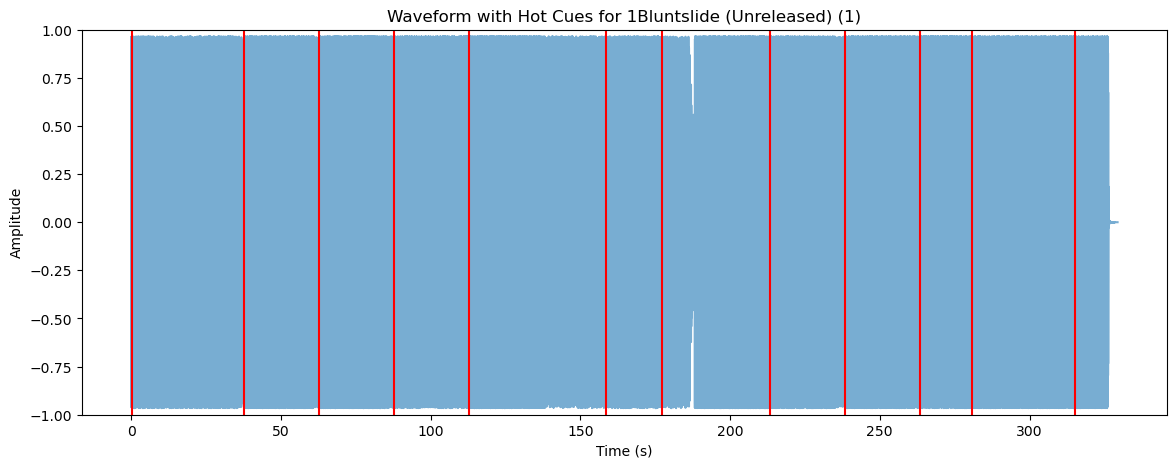

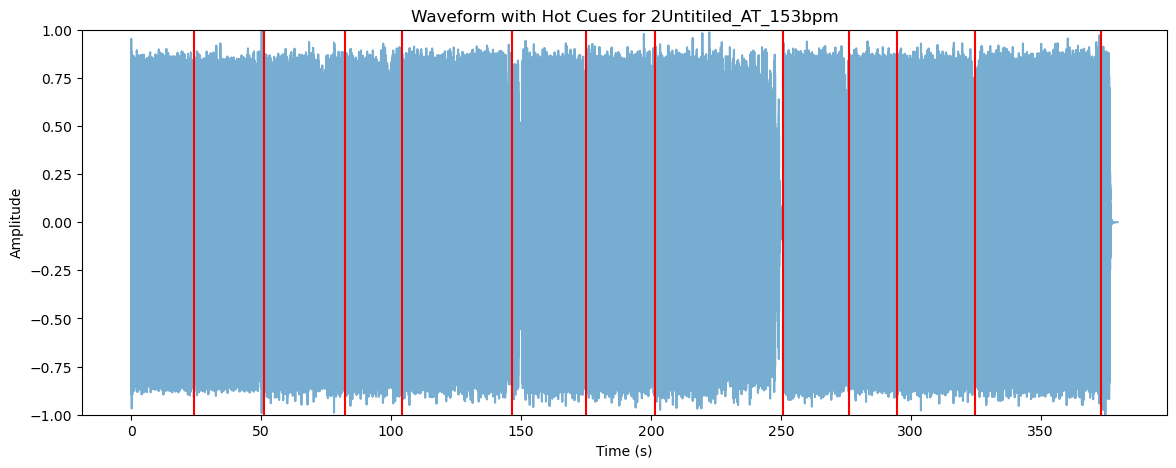

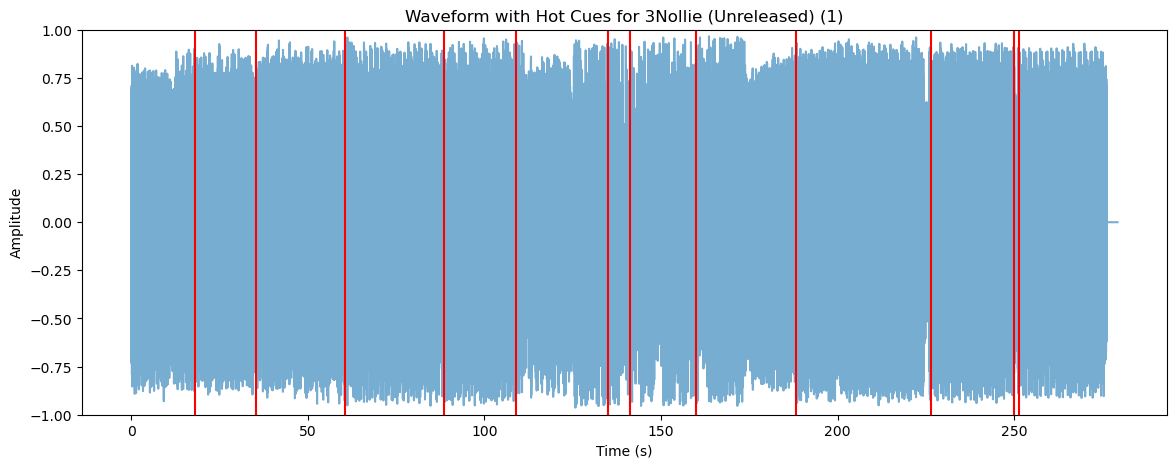

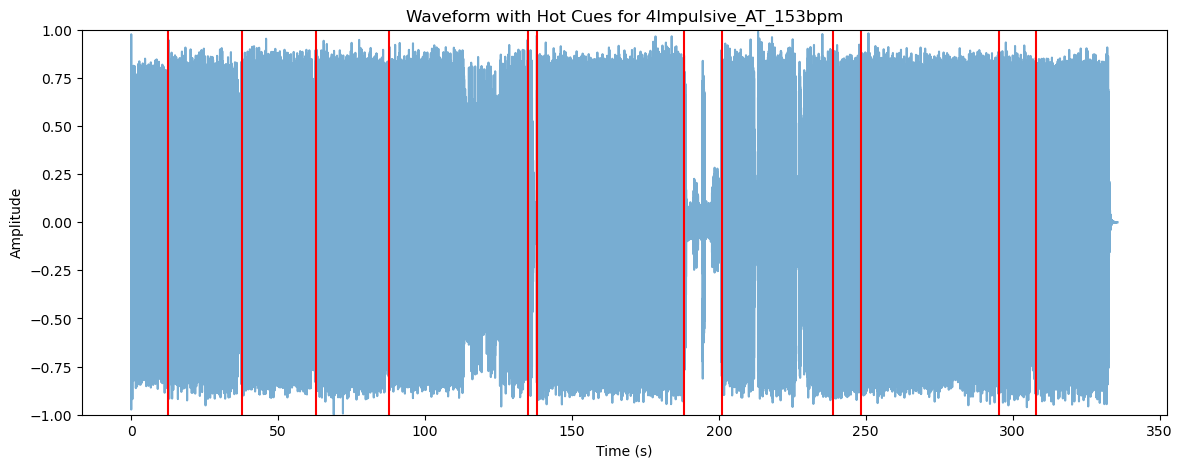

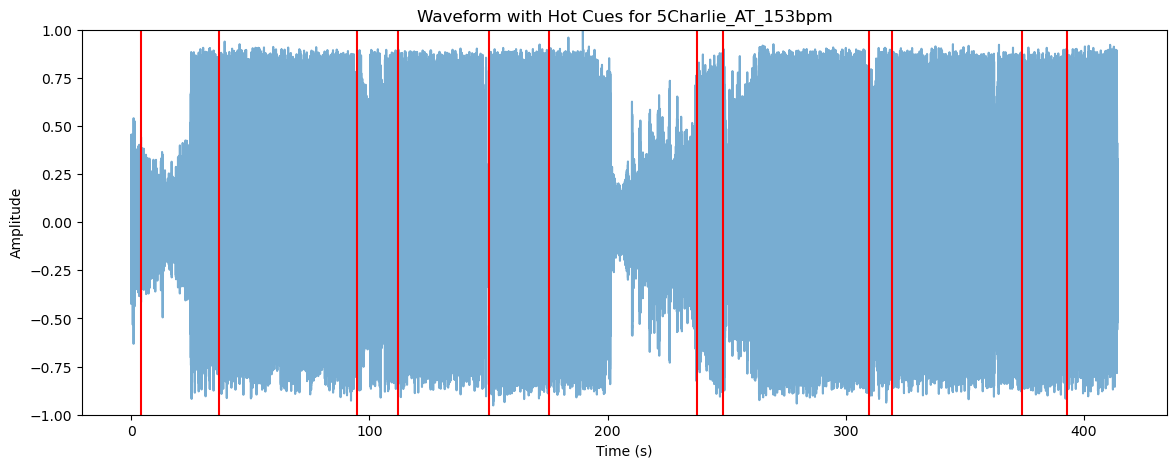

In [92]:
for track_name, track in tracks.items():
    plot_waveform_with_hot_cues(track.audio,track.sr,track.cue_points)

### CHANGING BPMS 

In [93]:
tracks

{'1Bluntslide': <__main__.Track at 0x189378750>,
 '2Untitiled_AT_153bpm': <__main__.Track at 0x189a5a490>,
 '3Nollie': <__main__.Track at 0x18a673710>,
 '4Impulsive_AT_153bpm': <__main__.Track at 0x18a2e1fd0>,
 '5Charlie_AT_153bpm': <__main__.Track at 0x18a3e5b10>}

In [ ]:
# import soundfile as sf

# def adjust_tempo_pyrb(input_file, output_file, tempo_ratio):
#     # Load the audio
#     audio, sr = librosa.load(input_file, sr=44100)
    
#     # Time stretch the audio
#     audio_adjusted = pyrb.time_stretch(audio, sr, tempo_ratio)
    
#     # Normalize the amplitude
#     audio_adjusted = audio_adjusted / np.max(np.abs(audio_adjusted))
    
#     # Write the adjusted audio to a .wav file
#     sf.write(output_file, audio_adjusted, sr)
    
#     return audio_adjusted, output_file



# def calculate_tempo_ratio(master, slave):
#     ratio = master.tempo/slave.tempo
#     print(ratio)
#     print(slave.tempo * ratio)
#     print(master.tempo)
#     print(slave.tempo)
#     return ratio

# def adjust_tempo_and_analyze(master_key, slave_key, tracks_dict):
#     master = tracks_dict[master_key]
#     slave = tracks_dict[slave_key]

#     # Calculate the tempo ratio
#     tempo_ratio = calculate_tempo_ratio(master, slave)

#     # Adjust the tempo of the slave track using pyrubberband
#     adjusted_audio, output_file = adjust_tempo_pyrb(slave.wav_file, f"{slave_key}_AT_{master.tempo}bpm.wav", tempo_ratio)

#     # Create a new Track instance for the adjusted audio
#     adjusted_slave = Track(f"{slave_key}_AT_{master.tempo}bpm", output_file)

#     # Add the adjusted track to the tracks dictionary
#     tracks_dict[f"{slave_key}_AT_{master.tempo}bpm"] = adjusted_slave

#     # Preprocess the adjusted track
#     preprocess_track(adjusted_slave)
#     #detect_cue_points_for_track(adjusted_slave, num_cue_points=12)
    
#     return adjusted_slave

### CROSS FADE 

In [136]:
def crossfade_tracks(track1, track2, cue_points1, cue_points2, crossfade_duration, sr):
    
    crossfade_cue_point1 = cue_points1
    crossfade_cue_point2 = cue_points2

    # Cut the tracks at the cue points
    track1_cut = track1[:int(crossfade_cue_point1 * sr)]
    track2_cut = track2[int(crossfade_cue_point2 * sr):]

    # Crossfade
    crossfade = np.linspace(0, 1, int(crossfade_duration * sr))
    track1_fadeout = track1_cut[-len(crossfade):] * (1 - crossfade)
    track2_fadein = track2_cut[:len(crossfade)] * crossfade

    # Combine the tracks
    combined = np.concatenate([track1_cut[:-len(crossfade)], track1_fadeout + track2_fadein, track2_cut[len(crossfade):]])

    return combined


### EQ FREQUENCIES 

In [94]:
def lin2db(linval):
    if linval > 1e-5:
        return 20.0 * math.log10(linval)
    else:
        return -100.0

def db2lin(dbval):
    return math.pow(10, dbval / 20.0)

def adjust_highs(audio, sr, gain_db):
    # High shelf filter starting from 2kHz
    filter_obj = yodel.filter.Biquad()
    filter_obj.high_shelf(sr, 2000, 1, gain_db)  # 2000 Hz
    output = np.zeros_like(audio)
    filter_obj.process(audio, output)
    return output

def adjust_lows(audio, sr, gain_db):
    # Low shelf filter ending at 500Hz
    filter_obj = yodel.filter.Biquad()
    filter_obj.low_shelf(sr, 500, 1, gain_db)  # 500 Hz
    output = np.zeros_like(audio)
    filter_obj.process(audio, output)
    return output

def adjust_audio(audio, sr, gains):
    # gains should be a list of two values: [gain_lows, gain_highs]
    # Each gain value should be between -1 and 1, where -1 corresponds to -∞ dB (muted) and 1 corresponds to 0 dB (normal level)
    
    #print(f"adjust_audio - input audio length: {len(audio)}")
    if len(audio) == 0:
        print("Empty audio slice received!")
        return audio
    
    # Convert gains to dB
    gain_lows_db = 20 * np.log10(gains[0]) if gains[0] > 0 else -np.inf
    gain_highs_db = 20 * np.log10(gains[1]) if gains[1] > 0 else -np.inf

    # Adjust audio using the defined gains
    audio = adjust_lows(audio, sr, gain_lows_db)
    audio = adjust_highs(audio, sr, gain_highs_db)

    # Rescale audio to be within [-1, 1]
    max_val = np.max(np.abs(audio))
    if max_val != 0:
        audio = audio / max_val
    
    return audio

# def adjust_audio(audio, sr, gains):
#     """Adjust the audio based on the specified gains."""
#     if len(audio) == 0:  # Check if the audio segment is empty
#         return audio  # Return the empty audio segment without processing
    

#     #gain_lows_db, gain_highs_db = gains
    
#     # Convert gains to dB
#     gain_lows_db = 20 * np.log10(gains[0]) if gains[0] > 0 else -np.inf
#     gain_highs_db = 20 * np.log10(gains[1]) if gains[1] > 0 else -np.inf

#     # Apply the EQ changes
#     audio = adjust_lows(audio, sr, gain_lows_db)
#     audio = adjust_highs(audio, sr, gain_highs_db)

#     # Rescale audio to be within [-1, 1]
#     max_val = np.max(np.abs(audio))
#     if max_val != 0:
#         audio = audio / max_val

#     return audio

In [95]:
### Rapid EQ 

def rapid_eq(audio, sr, gains, cue_times, chunk_size=44100):
    # Calculate the cue samples
    cue_samples = [int(t * sr) for t in cue_times]
    
    # Create a new array to hold the processed audio
    processed_audio = np.zeros_like(audio)
    
    # Apply the EQ changes in chunks
    for i in range(len(cue_samples) - 1):
        # Calculate the slope of the EQ change for this period
        slope_lows = (gains[i + 1][0] - gains[i][0]) / (cue_samples[i + 1] - cue_samples[i])
        slope_highs = (gains[i + 1][1] - gains[i][1]) / (cue_samples[i + 1] - cue_samples[i])
        
        for j in range(cue_samples[i], cue_samples[i + 1], chunk_size):
            # Calculate the current time in seconds
            current_time = j / sr
            
            # Calculate the current gains
            current_gain_lows = gains[i][0] + slope_lows * (current_time - cue_times[i])
            current_gain_highs = gains[i][1] + slope_highs * (current_time - cue_times[i])
            
            # Ensure the gains never drop below a small positive value
            current_gain_lows = max(current_gain_lows, 0.01)
            current_gain_highs = max(current_gain_highs, 0.01)
            
            # Calculate the chunk end sample
            end_j = min(j + chunk_size, len(audio))
            
            # Apply the EQ changes
            processed_audio[j:end_j] = adjust_audio(audio[j:end_j], sr, [current_gain_lows, current_gain_highs])
    
    # After the last cue time, keep the EQ changes at the last gains
    if cue_samples[-1] < len(audio):
        processed_audio[cue_samples[-1]:] = adjust_audio(audio[cue_samples[-1]:], sr, gains[-1])
    
    return processed_audio

In [96]:
def sigmoid(x, slope=10):
    return 1 / (1 + np.exp(-slope * x))

def smooth_eq(audio, sr, gains, cue_times, chunk_size=44100):
    # Calculate the cue samples
    cue_samples = [int(t * sr) for t in cue_times]
    
    # Create a new array to hold the processed audio
    processed_audio = np.zeros_like(audio)
    
    # Apply the EQ changes in chunks
    for i in range(len(cue_samples) - 1):
        print(f"smooth_eq - iteration {i}, processed_audio length before: {len(processed_audio)}")
        # Calculate the length of the transition in samples
        transition_length = cue_samples[i + 1] - cue_samples[i]
        
        for j in range(cue_samples[i], cue_samples[i + 1], chunk_size):
            # Calculate the proportion of the transition that has elapsed,
            # adjusted to go from -2 to 2 rather than from 0 to 1
            transition_progress = 4 * (j - cue_samples[i]) / transition_length - 2
            
            # Use the sigmoid function with the slope to calculate the current gains
            slope = 5  # adjust this value as desired
            gain_transition = sigmoid(transition_progress, slope)
            current_gain_lows = gains[i][0] + (gains[i + 1][0] - gains[i][0]) * gain_transition
            current_gain_highs = gains[i][1] + (gains[i + 1][1] - gains[i][1]) * gain_transition

            # Ensure the gains never drop below a small positive value
            current_gain_lows = max(current_gain_lows, 0.01)
            current_gain_highs = max(current_gain_highs, 0.01)
            
            # Calculate the chunk end sample
            end_j = min(j + chunk_size, len(audio))
            
            # Apply the EQ changes
            processed_audio[j:end_j] = adjust_audio(audio[j:end_j], sr, [current_gain_lows, current_gain_highs])
    
    print(f"smooth_eq - iteration {i}, processed_audio length after: {len(processed_audio)}")
    # After the last cue time, keep the EQ changes at the last gains
    if cue_samples[-1] < len(audio):
        processed_audio[cue_samples[-1]:] = adjust_audio(audio[cue_samples[-1]:], sr, gains[-1])
    
    return processed_audio


In [97]:
### Creating EQ-ied tracks 

In [98]:
def normalize_audio_gain(audio, target = -6):
    # Calculate the current gain of the audio
    rgain = 10 * np.log10(np.mean(audio**2))
    
    # Calculate the normalization factor
    factor = 10**((-(target - rgain)/10.0) / 2.0) # Divide by 2 because we want sqrt (amplitude^2 is energy)
    
    # Normalize the audio
    audio_normalized = audio * factor
    
    return audio_normalized

In [34]:
# ### EQ BASS this goes away im pretty sure 

# def create_eq_adjusted_tracks(track1, track2, t1_bass, t2_bass, sr):
#     # Define the gains and cue times for track1 (the master)
#     gains1_bass = [[1,1], [0.01, 1]]
#     cue_times1_bass = [0, t1_bass]

#     # Define the gains and cue times for track2 (the slave)
#     gains2_bass = [[0.01,1], [1, 1]]
#     cue_times2_bass = [0, t2_bass]

#     # Apply the EQ changes to the tracks
#     track1_eq_bass = rapid_eq(track1, sr, gains1_bass, cue_times1_bass)
#     track2_eq_bass = rapid_eq(track2, sr, gains2_bass, cue_times2_bass)

#     return track1_eq_bass, track2_eq_bass

In [35]:
# ### EQ TREBLE  same for this 

# def create_eq_adjusted_tracks_treble(track1, track2, t1_treble, t2_treble, duration, sr):
#     # Define the gains and cue times for track1 (the master)
#     gains1_treble = [[1, 1], [1, 1], [1, 1], [1, 0.7], [1, 0.4], [1, 0.1]]
#     cue_times1_treble = [0, t1_treble, t1_treble + 0.1*duration, t1_treble + 0.2*duration, t1_treble + 0.8*duration, t1_treble + duration]


#     # Define the gains and cue times for track2 (the slave)
#     gains2_treble = [[1, 0.1],[1, 0.1],[1, 0.5],[1, 0.9],[1, 1]]
#     cue_times2_treble = [0, t2_treble, t2_treble+0.2*duration, t2_treble+0.8*duration, t2_treble+duration]

#     # Apply the EQ changes to the tracks
#     track1_eq_treble = smooth_eq(track1, sr, gains1_treble, cue_times1_treble)
#     track2_eq_treble = smooth_eq(track2, sr, gains2_treble, cue_times2_treble)

#     return track1_eq_treble, track2_eq_treble

In [36]:
# def overlap_tracks(master, slave, master_cue, slave_cue, sr):
#     # Convert the cue points to sample indices
#     master_cue_samples = int(master_cue * sr)
#     slave_cue_samples = int(slave_cue * sr)
    
#     # Extract portions of each track
#     master_before_cue = master[:master_cue_samples]
#     slave_from_cue = slave[slave_cue_samples:]
    
#     # Calculate required padding for the slave track
#     padding_length = master_cue_samples - slave_cue_samples
#     padding = np.zeros(padding_length)
    
#     # Pad the slave track to align with the master's cue point
#     slave_padded = np.concatenate([padding, slave_from_cue])
    
#     # Combine the master track and padded slave track
#     combined_length = max(len(master), len(slave_padded))
#     combined = np.zeros(combined_length)
    
#     combined[:len(master)] += master
#     combined[:len(slave_padded)] += slave_padded
    
#     return combined

# def combine_multiple_tracks(tracks, cues, sr):
#     combined_mix = tracks[0]  # Start with the first track
    
#     # Calculate where in the mix each track should start
#     cumulative_cue = 0
    
#     # Loop until the second last track
#     for i in range(1, len(tracks) - 1):
#         master_cue = cumulative_cue + cues[2*(i-1)]
#         slave_cue = cues[2*(i-1) + 1]
        
#         combined_mix = overlap_tracks(combined_mix, tracks[i], master_cue, slave_cue, sr)
#         cumulative_cue += cues[2*(i-1)]
    
#     # Handle the last track separately
#     last_track_cue_in = cues[-1]
#     combined_mix = overlap_tracks(combined_mix, tracks[-1], cumulative_cue + last_track_cue_in, last_track_cue_in, sr)
        
#     return combined_mix

In [46]:

# ### Adding randomness to the mix 

# import random

# y = random.randint(1,2)
# z = random.choice([4, 8, 16, 32])
# x = beats_to_seconds(a.tempo, z)

# print(y)
# print(z)
# print(x)

# aout_index = (-1)*random.randint(3,6)
# bin_index = random.randint(0,4)
# bassup_index = bin_index+y

# print(aout_index)
# print(bin_index)
# print(bassup_index)

# acue_out = a.cue_points[aout_index]
# bcue_in = b.cue_points[bin_index]
# bbass = b.cue_points[bin_index+y]
# abass = acue_out + (bbass-bcue) - x  

# print(acue_out)
# print(bcue_in)
# print(bbass)
# print(abass)

In [47]:
### STAD W DOL 

In [99]:
tracks

{'1Bluntslide': <__main__.Track at 0x189378750>,
 '2Untitiled_AT_153bpm': <__main__.Track at 0x189a5a490>,
 '3Nollie': <__main__.Track at 0x18a673710>,
 '4Impulsive_AT_153bpm': <__main__.Track at 0x18a2e1fd0>,
 '5Charlie_AT_153bpm': <__main__.Track at 0x18a3e5b10>}

In [100]:
track_list = [tracks[key] for key in tracks]


In [101]:
def beats_to_seconds(bpm, beats):
    beats_per_second = bpm / 60
    seconds = beats / beats_per_second
    return seconds

In [102]:
import random

def generate_track_cue_in_out(tracks):
    """Generate cue in and cue out points for tracks."""
    cue_in_out_points = []

    # For the first track (only cue out)
    aout_index = random.randint(6, 9)
    acue_out = tracks[0].cue_points[aout_index]
    cue_in_out_points.append((None, acue_out))

    # For the middle tracks (both cue in and cue out)
    for i in range(1, len(tracks) - 1):
        bin_index = random.randint(0, 2)
        bout_index = random.randint(6, 9)
        bcue_in = tracks[i].cue_points[bin_index]
        bcue_out = tracks[i].cue_points[bout_index]
        cue_in_out_points.append((bcue_in, bcue_out))

    # For the last track (only cue in)
    # bylo (0,3)
    cin_index = random.randint(0, 2)
    ccue_in = tracks[-1].cue_points[cin_index]
    cue_in_out_points.append((ccue_in, None))

    return cue_in_out_points

In [103]:
def generate_bass_cue_points(cue_in_out_points, tracks):
    """Generate bass up and down points for tracks."""
    bass_cue_points = []

    # Initial values
    #y = random.choice([1, 2, 3])
    y = random.choice([2, 3])
    
    #z = random.choice([4, 8, 16, 32])
    z = random.choice([4, 8]) # bylo 16
    
    x = beats_to_seconds(tracks[0].tempo, z)

    # First track has only bass down
    acue_out = cue_in_out_points[0][1]
    bin_index = tracks[1].cue_points.index(cue_in_out_points[1][0])
    bbass_up_index = bin_index + y
    bbass_up = tracks[1].cue_points[bbass_up_index]
    abass_down = acue_out + (bbass_up - tracks[1].cue_points[bin_index]) - x
    bass_cue_points.append((None, abass_down))

    # Middle tracks
    for i in range(1, len(cue_in_out_points) - 1):
        bcue_in = cue_in_out_points[i][0]
        bcue_out = cue_in_out_points[i][1]
        
        y = random.choice([2, 3])
        z = random.choice([4, 8])
        x = beats_to_seconds(tracks[i].tempo, z)
        
        bin_index = tracks[i].cue_points.index(bcue_in)
        bbass_up_index = bin_index + y
        bbass_up = tracks[i].cue_points[bbass_up_index]
        
        cin_index = tracks[i+1].cue_points.index(cue_in_out_points[i+1][0])
        cbass_up_index = cin_index + y
        cbass_up = tracks[i+1].cue_points[cbass_up_index]

        bbass_down = bcue_out + (cbass_up - tracks[i+1].cue_points[cin_index]) - x
        
        bass_cue_points.append((bbass_up, bbass_down))

    # Last track has only bass up
    ccue_in = cue_in_out_points[-1][0]
    cin_index = tracks[-1].cue_points.index(ccue_in)
    cbass_up_index = cin_index + y
    cbass_up = tracks[-1].cue_points[cbass_up_index]
    bass_cue_points.append((cbass_up, None))

    return bass_cue_points

In [104]:
def generate_all_cue_points(tracks):
    """Generate all cue and bass points for tracks."""
    
    # Step 1: Get the cue in/out points
    cue_in_out_points = generate_track_cue_in_out(tracks)
    
    # Step 2: Get the bass cue points
    bass_cue_points = generate_bass_cue_points(cue_in_out_points, tracks)
    
    # Step 3: Combine and return the results
    combined_cue_points = [(cue[0], cue[1], bass[0], bass[1]) for cue, bass in zip(cue_in_out_points, bass_cue_points)]
    
    return cue_in_out_points, bass_cue_points, combined_cue_points


In [105]:
def generate_cue_points_matrix(tracks):
    """Generate a matrix of cue and bass points for tracks."""
    
    # Get all cue points using the existing function
    cue_in_out_points, bass_cue_points, combined_cue_points = generate_all_cue_points(tracks)
    
    # Create a matrix with header and placeholder rows
    matrix = [["Track", "Cue-In", "Cue-Out", "Bass-Up", "Bass-Down"]]
    matrix.extend([['None', 'None', 'None', 'None', 'None'] for _ in range(len(tracks))])
    
    for i in range(len(cue_in_out_points)):
        track_name = f"Track {i+1}"
        cue_in, cue_out = cue_in_out_points[i]
        bass_up, bass_down = bass_cue_points[i]
        
        # Update the row instead of appending
        matrix[i+1] = [track_name, cue_in, cue_out, bass_up, bass_down]
    
    return cue_in_out_points, bass_cue_points, combined_cue_points, matrix


In [106]:
# Generate the cue points matrix
cue_in_out_points, bass_cue_points, combined_cue_points, matrix = generate_cue_points_matrix(track_list)

In [107]:
flattened_cue_in_out = [item for sublist in cue_in_out_points for item in sublist if item is not None]
flattened_cue_in_out

[238.43, 50.98, 294.9, 35.29, 226.28, 12.55, 238.83, 94.9]

In [108]:
flattened_bass_cues = [item for sublist in bass_cue_points for item in sublist if item is not None]
flattened_bass_cues

[332.5413725490196,
 104.32,
 345.1027450980392,
 88.63,
 273.34274509803925,
 87.83,
 316.08274509803925,
 175.29]

In [109]:
combined_cue_points

[(None, 238.43, None, 332.5413725490196),
 (50.98, 294.9, 104.32, 345.1027450980392),
 (35.29, 226.28, 88.63, 273.34274509803925),
 (12.55, 238.83, 87.83, 316.08274509803925),
 (94.9, None, 175.29, None)]

In [110]:
matrix

[['Track', 'Cue-In', 'Cue-Out', 'Bass-Up', 'Bass-Down'],
 ['Track 1', None, 238.43, None, 332.5413725490196],
 ['Track 2', 50.98, 294.9, 104.32, 345.1027450980392],
 ['Track 3', 35.29, 226.28, 88.63, 273.34274509803925],
 ['Track 4', 12.55, 238.83, 87.83, 316.08274509803925],
 ['Track 5', 94.9, None, 175.29, None]]

In [111]:
### EQ BASS 

# zmieniamy z 0.1 na 0.01 JESZCZE NIE 

def create_eq_adjusted_tracks(track1, track2, t1_bass, t2_bass, sr):
    # Define the gains and cue times for track1 (the master)
    gains1_bass = [[1, 1], [0.01, 1]]
    cue_times1_bass = [0, t1_bass]

    # Define the gains and cue times for track2 (the slave)
    gains2_bass = [[0.01, 1], [1, 1]]
    cue_times2_bass = [0, t2_bass]

    # Apply the EQ changes to the tracks
    track1_eq_bass = rapid_eq(track1, sr, gains1_bass, cue_times1_bass)
    track2_eq_bass = rapid_eq(track2, sr, gains2_bass, cue_times2_bass)

    return track1_eq_bass, track2_eq_bass

### BASSL

def generate_eq_adjusted_tracks(tracks, bass_cues, sr):
    eq_adjusted_tracks = []
    
    # For the first track (only bass down)
    first_track_eq, _ = create_eq_adjusted_tracks(tracks[0], tracks[1], bass_cues[0], bass_cues[1], sr)
    eq_adjusted_tracks.append(first_track_eq)
    
    # For the middle tracks (both bass up and bass down)
    for i in range(1, len(tracks) - 1):
        print(f"we are doing track{i}")
        # Adjust bass up
        _, track_with_bass_up = create_eq_adjusted_tracks(tracks[i-1], tracks[i], bass_cues[2*i-2], bass_cues[2*i-1], sr)
        
        # Adjust bass down for the same track
        track_with_bass_down, _ = create_eq_adjusted_tracks(track_with_bass_up, tracks[i+1], bass_cues[2*i], bass_cues[2*i+1], sr)
        
        eq_adjusted_tracks.append(track_with_bass_down)
    
    # For the last track (only bass up)
    _, last_track_eq = create_eq_adjusted_tracks(tracks[-2], tracks[-1], bass_cues[-2], bass_cues[-1], sr)
    eq_adjusted_tracks.append(last_track_eq)
    
    return eq_adjusted_tracks


In [125]:
flattened_bass_cues

[332.5413725490196,
 104.32,
 345.1027450980392,
 88.63,
 273.34274509803925,
 87.83,
 316.08274509803925,
 175.29]

In [126]:
eqbass

[array([ 4.3617957e-03,  6.0031139e-03,  9.2827845e-03, ...,
        -1.0988308e-02,  6.4268261e-07, -2.1977382e-02], dtype=float32),
 array([-1.5892651e-03, -3.7735628e-03, -2.8469502e-03, ...,
        -4.4420458e-06, -4.0760533e-06, -3.5993928e-06], dtype=float32),
 array([ 1.7671880e-03, -1.5793993e-03,  1.0486702e-03, ...,
         1.0699046e-07,  2.2283674e-08,  1.4887012e-08], dtype=float32),
 array([ 1.2638686e-02,  2.8662656e-03,  1.1117719e-02, ...,
        -3.1367061e-05, -1.4431711e-05, -2.5440968e-05], dtype=float32),
 array([-0.00139275, -0.00168825, -0.00089402, ...,  0.0019246 ,
        -0.02352294, -0.02144559], dtype=float32)]

In [112]:
audio_list = [track.audio for track in track_list]
eqbass = generate_eq_adjusted_tracks(audio_list, flattened_bass_cues,track_list[0].sr)

#eqbass = generate_eq_adjusted_tracks([a.audio,b.audio,c.audio,d.audio],flattened_bass_cues,a.sr)


Empty audio slice received!
Empty audio slice received!
Empty audio slice received!
we are doing track1
Empty audio slice received!
Empty audio slice received!
Empty audio slice received!
we are doing track2
we are doing track3


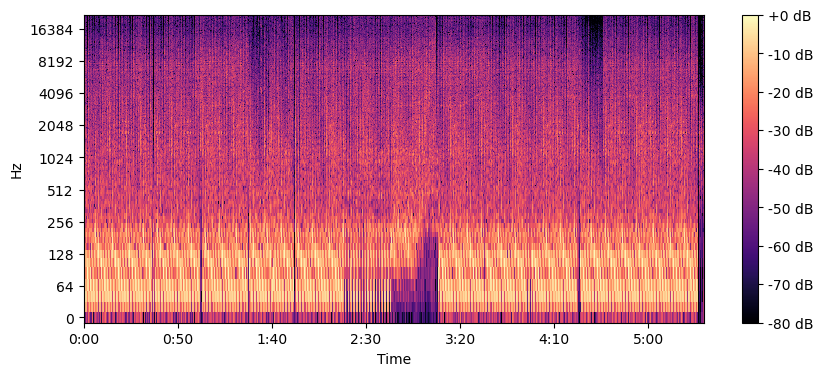

In [121]:
plot_spectrogram(eqbass[0],track_list[0].sr)

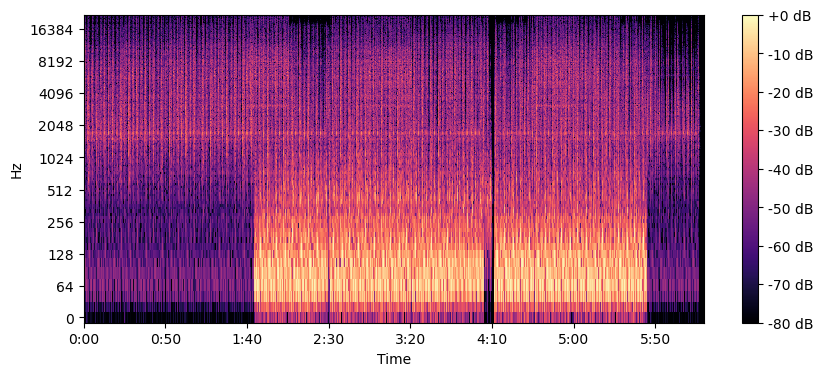

In [122]:
plot_spectrogram(eqbass[1],track_list[0].sr)

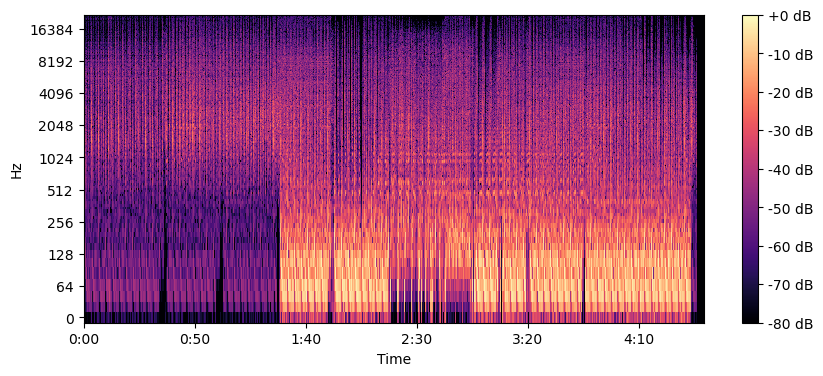

In [123]:
plot_spectrogram(eqbass[2],track_list[0].sr)

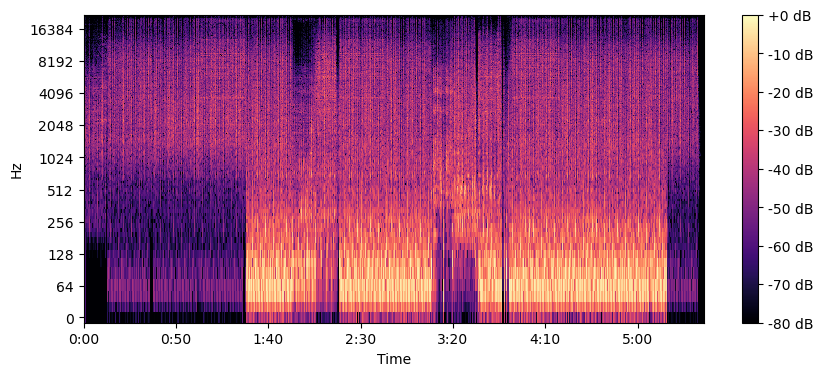

In [124]:
plot_spectrogram(eqbass[3],track_list[0].sr)

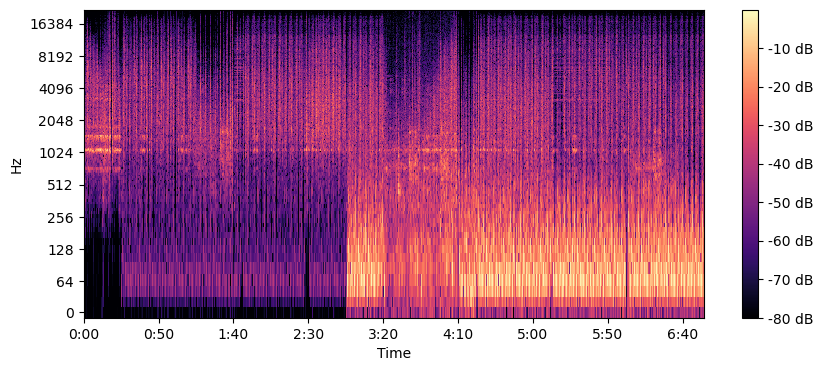

In [127]:
plot_spectrogram(eqbass[4],track_list[0].sr)

In [94]:
plot_spectrogram(eqbass[1],track_list[0].sr)

In [ ]:
plot_spectrogram(eqbass[2],track_list[0].sr)

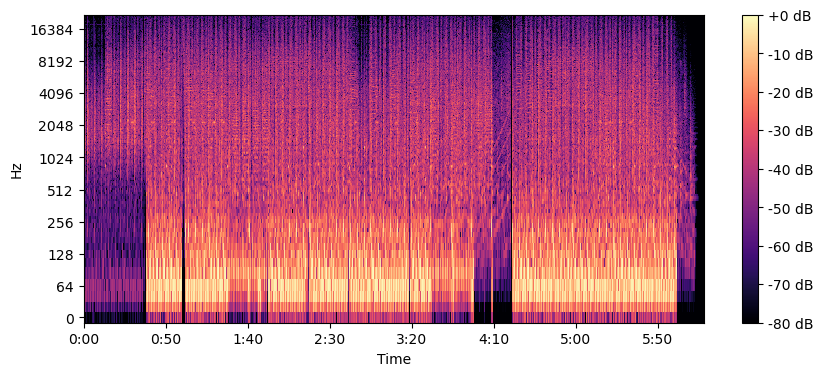

In [96]:
plot_spectrogram(eqbass[3],track_list[0].sr)

In [ ]:
matrix

In [87]:
matrix[1][2]

174.95

In [88]:
matrix[2][3]

108.62

In [91]:
matrix[2][1]

81.57

In [113]:
def track_fade_out(track, t_treble, duration, sr):
    """Adjust treble for the track fading out."""
    gains = [[1, 1],[1, 1] ,[1, 0.8], [1, 0.6], [1, 0.4], [1, 0.2], [0.01, 0.01]]
    cue_times = [0, t_treble, t_treble +0.1*duration, t_treble + 0.2*duration, t_treble + 0.4*duration, t_treble + 0.8*duration, t_treble + duration+10]
    print(f"track_fade_out - t_treble: {t_treble}, duration: {duration}, cue_times: {cue_times}")
    return smooth_eq(track, sr, gains, cue_times)

# def track_fade_in(track, t_treble, duration, sr):
#     """Adjust treble for the track fading in."""
#     gains = [[0.5, 0], [1, 0.6], [1, 0.9], [1, 1], [1, 1], [1, 1]]
#     cue_times = [0, t_treble, t_treble + 0.2*duration, t_treble + 0.4*duration, t_treble + 0.8*duration, t_treble + duration+10]
#     print(f"track_fade_in - t_treble: {t_treble}, duration: {duration}, cue_times: {cue_times}")
#     return smooth_eq(track, sr, gains, cue_times)

# def track_fade_in(track, t_treble, duration, sr):
#     """Adjust treble for the track fading in."""
#     gains = [[0.01, 0.01], [1, 0.6], [1, 0.9], [1, 1], [1, 1], [1, 1]]
#     cue_times = [0, t_treble, t_treble + 0.2*duration, t_treble + 0.4*duration, t_treble + 0.8*duration, t_treble + duration+10]
#     print(f"track_fade_in - t_treble: {t_treble}, duration: {duration}, cue_times: {cue_times}")
#     return smooth_eq(track, sr, gains, cue_times)

def track_fade_in(track, t_treble, duration, sr):
    """Adjust treble for the track fading in."""
    gains = [[0.01, 0.01], [0.01, 0.01], [0.6, 0.8], [1, 1], [1, 1], [1, 1]]
    cue_times = [0, t_treble, t_treble + 0.3*duration, t_treble + 0.4*duration, t_treble + 0.8*duration, t_treble + duration+10]
    print(f"track_fade_in - t_treble: {t_treble}, duration: {duration}, cue_times: {cue_times}")
    return smooth_eq(track, sr, gains, cue_times)

def generate_treble_adjusted_tracks(tracks, cue_matrix, sr):
    treble_adjusted_tracks = []
      
    # For the first track (only fade out)
    
    # First duration is difference between 
    duration_out_first = float(cue_matrix[2][3] if cue_matrix[2][3] else 0) - float(cue_matrix[2][1] if cue_matrix[2][1] else 0)
    
    # it starts at first tracks cue out
    treble_out_first = float(cue_matrix[1][2] if cue_matrix[1][2] else 0)
    
    print(f"First track - duration_out: {duration_out_first}")
    
    first_track_treble = track_fade_out(tracks[0], treble_out_first, duration_out_first, sr)
    treble_adjusted_tracks.append(first_track_treble)
    
    for i in range(1, len(tracks) - 1):  # This will loop over the 2nd and 3rd tracks in the tracks list
        # For fade-in of the track
        duration_in = float(cue_matrix[i+1][2] if cue_matrix[i+1][2] else 0) - float(cue_matrix[i+1][1] if cue_matrix[i+1][1] else 0)
        treble_in = float(cue_matrix[i+1][1] if cue_matrix[i+1][1] else 0)
        treble_adjusted_track_in = track_fade_in(tracks[i], treble_in, duration_in, sr)

        # For fade-out of the track
        duration_out = float(cue_matrix[i+2][3] if cue_matrix[i+2][3] else 0) - float(cue_matrix[i+2][1] if cue_matrix[i+2][1] else 0)
        treble_out = float(cue_matrix[i+1][2] if cue_matrix[i+1][2] else 0)
        treble_adjusted_track_out = track_fade_out(treble_adjusted_track_in, treble_out, duration_out, sr)

        treble_adjusted_tracks.append(treble_adjusted_track_out)
        
        # That ends the iteration 
        
    
    # For the last track (only fade in) 
    # Difference between its bass up and cue in - 5 seconds) so its loud 5 seconds before it drops 
    duration_in_last = float(cue_matrix[-1][3] if cue_matrix[-1][3] else 0) - float(cue_matrix[-1][1] if cue_matrix[-1][1] else 0)
    # tracks cue in 
    treble_in_last = float(cue_matrix[-1][1] if cue_matrix[-1][1] else 0)
    
    last_track_treble = track_fade_in(tracks[-1], treble_in_last, duration_in_last, sr)
    treble_adjusted_tracks.append(last_track_treble)
    
    return treble_adjusted_tracks

In [114]:

# For demonstration purposes
treble_tracks = generate_treble_adjusted_tracks(eqbass, matrix, 44100)


First track - duration_out: 53.339999999999996
track_fade_out - t_treble: 238.43, duration: 53.339999999999996, cue_times: [0, 238.43, 243.764, 249.098, 259.766, 281.102, 301.77]
smooth_eq - iteration 0, processed_audio length before: 14527059
smooth_eq - iteration 1, processed_audio length before: 14527059
smooth_eq - iteration 2, processed_audio length before: 14527059
smooth_eq - iteration 3, processed_audio length before: 14527059
smooth_eq - iteration 4, processed_audio length before: 14527059
smooth_eq - iteration 5, processed_audio length before: 14527059
smooth_eq - iteration 5, processed_audio length after: 14527059
track_fade_in - t_treble: 50.98, duration: 243.92, cue_times: [0, 50.98, 124.15599999999998, 148.548, 246.11599999999999, 304.9]
smooth_eq - iteration 0, processed_audio length before: 16740706
smooth_eq - iteration 1, processed_audio length before: 16740706
smooth_eq - iteration 2, processed_audio length before: 16740706
smooth_eq - iteration 3, processed_audio le

In [128]:
def overlap_tracks(master, slave, master_cue, slave_cue, sr):
    # Convert the cue points to sample indices
    master_cue_samples = int(master_cue * sr)
    slave_cue_samples = int(slave_cue * sr)
    
    # Extract portions of each track
    master_before_cue = master[:master_cue_samples]
    slave_from_cue = slave[slave_cue_samples:]
    
    # Calculate required padding for the slave track
    padding_length = master_cue_samples - slave_cue_samples
    padding = np.zeros(padding_length)
    
    # Pad the slave track to align with the master's cue point
    slave_padded = np.concatenate([padding, slave_from_cue])
    
    # Combine the master track and padded slave track
    combined_length = max(len(master), len(slave_padded))
    combined = np.zeros(combined_length)
    
    combined[:len(master)] += master
    combined[:len(slave_padded)] += slave_padded
    
    return combined

# def overlap_tracks(master, slave, master_cue, slave_cue, sr):
#     # Convert the cue points to sample indices
#     master_cue_samples = int(master_cue * sr)
#     slave_cue_samples = int(slave_cue * sr)
    
#     # Extract portions of each track
#     master_before_cue = master[:master_cue_samples]
#     slave_from_cue = slave[slave_cue_samples:]
    
#     # Calculate required padding for the slave track
#     padding_length = master_cue_samples
#     padding = np.zeros(padding_length)
    
#     # Pad the slave track to align with the master's cue point
#     slave_padded = np.concatenate([padding, slave_from_cue])
    
#     # Combine the master track and padded slave track
#     combined_length = max(len(master), len(slave_padded))
#     combined = np.zeros(combined_length)
    
#     combined[:len(master)] += master
#     combined[:len(slave_padded)] += slave_padded
    
#     return combined


# def overlap_tracks(master, slave, master_cue, slave_cue, sr):
#     # Convert the cue points to sample indices
#     master_cue_samples = int(master_cue * sr)
#     slave_cue_samples = int(slave_cue * sr)
    
#     # Extract portions of each track
#     master_before_cue = master[:master_cue_samples]
#     slave_from_cue = slave[slave_cue_samples:]
    
#     # Calculate required padding for the slave track
#     padding_length = master_cue_samples
#     padding = np.zeros(padding_length)
    
#     # Pad the slave track to align with the master's cue point
#     slave_padded = np.concatenate([padding, slave_from_cue])
    
#     # Combine the master track and padded slave track
#     combined_length = max(len(master), len(slave_padded))
#     combined = np.zeros(combined_length)
    
#     combined[:len(master)] += master
#     combined[:len(slave_padded)] += slave_padded
    
#     return combined


# def combine_multiple_tracks(tracks, cues, sr):
#     combined_mix = tracks[0]  # Start with the first track
    
#     # Calculate where in the mix each track should start
#     cumulative_cue = 0
    
#     # Loop until the second last track
#     for i in range(1, len(tracks) - 1):
#         master_cue = cumulative_cue + cues[2*(i-1)]
#         slave_cue = cues[2*(i-1) + 1]
        
#         combined_mix = overlap_tracks(combined_mix, tracks[i], master_cue, slave_cue, sr)
#         cumulative_cue += cues[2*(i-1)]
    
#     # Handle the last track separately
#     last_track_cue_in = cues[-1]
#     combined_mix = overlap_tracks(combined_mix, tracks[-1], cumulative_cue + last_track_cue_in, last_track_cue_in, sr)
        
#     return combined_mix

# def combine_multiple_tracks(tracks, cues, sr):
#     combined_mix = tracks[0]  # Start with the first track
    
#     # Calculate where in the mix each track should start
#     cumulative_cue = 0
    
#     # Loop until the second last track
#     for i in range(1, len(tracks) - 1):
#         master_cue = cumulative_cue + cues[2*(i-1)]
#         slave_cue = cues[2*(i-1) + 1]
        
#         combined_mix = overlap_tracks(combined_mix, tracks[i], master_cue, slave_cue, sr)
#         cumulative_cue = len(combined_mix) / sr  # Update cumulative_cue based on the current length of combined_mix
    
#     # Handle the last track separately
#     last_track_cue_in = cues[-1]
#     combined_mix = overlap_tracks(combined_mix, tracks[-1], cumulative_cue + last_track_cue_in, last_track_cue_in, sr)
        
#     return combined_mix

def combine_multiple_tracks(tracks, cues, sr):
    combined_mix = tracks[0]  # Start with the first track
    
    # Calculate where in the mix each track should start
    cumulative_cue = cues[0]  # Start with Track 1 cue out
    
    # Loop until the second last track
    for i in range(1, len(tracks) - 1):
        master_cue = cumulative_cue
        slave_cue = cues[2*(i-1) + 1]
        
        # Print the values for inspection
        print(f"i: {i}, master_cue: {master_cue}, slave_cue: {slave_cue}, cumulative_cue: {cumulative_cue}")
        
        combined_mix = overlap_tracks(combined_mix, tracks[i], master_cue, slave_cue, sr)
        
        # Update cumulative_cue for the next iteration
        cumulative_cue += cues[2*i] - slave_cue
    
    # Handle the last track separately
    last_track_cue_in = cues[-1]
    combined_mix = overlap_tracks(combined_mix, tracks[-1], cumulative_cue + last_track_cue_in, last_track_cue_in, sr)
        
    return combined_mix

# def combine_multiple_tracks(tracks, cues, sr):
#     combined_mix = tracks[0]  # Start with the first track
    
#     # Calculate where in the mix each track should start
#     cumulative_cue = cues[0]  # Start with Track 1 cue out
    
#     # Loop until the second last track
#     for i in range(1, len(tracks) - 1):
#         master_cue = cumulative_cue
#         slave_cue = cues[2*(i-1) + 1]
        
#         # Print the values for inspection
#         print(f"i: {i}, master_cue: {master_cue}, slave_cue: {slave_cue}, cumulative_cue: {cumulative_cue}")
        
#         combined_mix = overlap_tracks(combined_mix, tracks[i], master_cue, slave_cue, sr)
        
#         # Update cumulative_cue for the next iteration
#         cumulative_cue += cues[2*i] - slave_cue
    
#     # Handle the last track separately
#     last_track_cue_in = cues[-1]
#     combined_mix = overlap_tracks(combined_mix, tracks[-1], cumulative_cue + last_track_cue_in, last_track_cue_in, sr)
        
#     return combined_mix



In [129]:
flattened_cue_in_out

[238.43, 50.98, 294.9, 35.29, 226.28, 12.55, 238.83, 94.9]

In [130]:
tracks

{'1Bluntslide': <__main__.Track at 0x189378750>,
 '2Untitiled_AT_153bpm': <__main__.Track at 0x189a5a490>,
 '3Nollie': <__main__.Track at 0x18a673710>,
 '4Impulsive_AT_153bpm': <__main__.Track at 0x18a2e1fd0>,
 '5Charlie_AT_153bpm': <__main__.Track at 0x18a3e5b10>}

In [118]:
### NOWY OGROMNY TEST

combined = combine_multiple_tracks(treble_tracks,flattened_cue_in_out,44100)

i: 1, master_cue: 238.43, slave_cue: 50.98, cumulative_cue: 238.43
i: 2, master_cue: 482.35, slave_cue: 35.29, cumulative_cue: 482.35
i: 3, master_cue: 673.34, slave_cue: 12.55, cumulative_cue: 673.34


In [133]:
#Audio(combined,rate = 44100)

In [134]:
#Audio(normalize_audio_gain(combined),rate = 44100)

In [ ]:
# lets go 


In [183]:

Track.clear_tracks()


In [184]:
import os
import random
from scipy.stats import mode
from IPython.display import Audio

def main_processing_function(path):
    # Get WAV files
    track_files = get_audio_files_from_path(path)
    print(track_files)

    # Instantiate and preprocess tracks
    tracks = instantiate_and_rename_tracks(track_files)
    for track_name, track_obj in tracks.items():
        preprocess_track(track_obj)

    # Print all BPM values
    for track_name, track_obj in tracks.items():
        print(f"{track_name}: {track_obj.tempo} BPM")
    print(f"Mode BPM: {get_mode_bpm(tracks)} BPM")

    # Adjust tracks to mode BPM
    tracks = adjust_tracks_to_mode_bpm(tracks)

    # Extract features for beats
    for track_name, track in tracks.items():
        track.extract_features_for_beats()
        
        
    # Cue point detection
    for track_name, track in tracks.items():
        track.prepare_features_for_prediction()
        # First run to determine the dominant array
        detect_cue_points_for_track(track, num_cue_points=64)
        dominant_key = categorize_cue_points(track.cue_points_indeces)
        
        # Second run with filtering
        detect_cue_points_for_track(track, num_cue_points=12, filter_by=dominant_key)
        
        print(f"Track: {track_name}")
        print(f"Cue Points (indices): {track.cue_points_indeces}")
        print(f"Cue Points: {track.cue_points}")
        print("------")

    # Generate the cue points matrix
    track_list = [tracks[key] for key in tracks]
    
    #cue_in_out_points, bass_cue_points, _, _ = generate_cue_points_matrix(track_list)
    
    # Generate the cue points matrix
    cue_in_out_points, bass_cue_points, combined_cue_points, matrix = generate_cue_points_matrix(track_list)

    flattened_cue_in_out = [item for sublist in cue_in_out_points for item in sublist if item is not None]
    flattened_bass_cues = [item for sublist in bass_cue_points for item in sublist if item is not None]

    # EQ adjustments
    audio_list = [track.audio for track in track_list]
    eqbass = generate_eq_adjusted_tracks(audio_list, flattened_bass_cues, track_list[0].sr)

    # Treble adjustments
    treble_tracks = generate_treble_adjusted_tracks(eqbass, matrix, 44100)

    # Combine tracks
    combined = combine_multiple_tracks(treble_tracks, flattened_cue_in_out, track_list[0].sr)

    return combined, treble_tracks, eqbass, flattened_cue_in_out, flattened_bass_cues

# Example Usage:
combined1,treble_tracks1,eqbass1,flattened_cue_in_out1,flattened_bass_cues1 = main_processing_function("kejsi420")


['kejsi420/Untitiled (Unreleased) (1).aif', 'kejsi420/Bluntslide (Unreleased) (1).aif', 'kejsi420/Whiplash (Unreleased) (1).aif', 'kejsi420/Nollie (Unreleased) (1).aif']
Estimated Tempo for Untitiled (Unreleased) (1): 155.00 BPM
Estimated Tempo for Bluntslide (Unreleased) (1): 153.00 BPM
Estimated Tempo for Whiplash (Unreleased) (1): 150.00 BPM
Estimated Tempo for Nollie (Unreleased) (1): 153.00 BPM
Untitiled: 155 BPM
Bluntslide: 153 BPM
Whiplash: 150 BPM
Nollie: 153 BPM
Mode BPM: 153 BPM
0.9870967741935484
153.0
153
155
Estimated Tempo for Untitiled_AT_153bpm: 153.00 BPM
1.02
153.0
153
150
Estimated Tempo for Whiplash_AT_153bpm: 153.00 BPM
Track: Untitiled_AT_153bpm
Cue Points (indices): [ 62 130 210 266 374 446 514 638 702 750 826 950]
Cue Points: [24.31, 50.98, 82.36, 104.32, 146.66, 174.9, 201.57, 250.98, 276.08, 294.9, 324.71, 373.33]
------
Track: Bluntslide
Cue Points (indices): [  1  97 161 225 289 405 453 545 609 673 717 805]
Cue Points: [0.39, 37.64, 62.75, 87.84, 112.94, 158

In [179]:
flattened_cue_in_out1

[250.98, 62.75, 177.26, 75.89, 174.71, 18.04]

In [181]:
combined_again = combine_multiple_tracks(treble_tracks1, flattened_cue_in_out1, 44100)

i: 1, master_cue: 250.98, slave_cue: 62.75, cumulative_cue: 250.98
i: 2, master_cue: 365.49, slave_cue: 75.89, cumulative_cue: 365.49


In [171]:
flattened_cue_in_out1

[201.57, 37.64, 263.53, 50.79, 276.67, 60.39]

In [135]:
#Audio(combined1,rate=44100)

In [136]:
#Audio(combined,rate = 44100)

In [145]:
flattened_cue_in_out

[204.02, 27.03, 158.6, 39.88, 164.6, 39.02, 219.46, 54.88]

In [131]:
apka = [['Track', 'Cue-In', 'Cue-Out', 'Bass-Up', 'Bass-Down'],
 ['Track 1', None, 238.43, None, 332.54],
 ['Track 2', 50.98, 294.9, 104.32, 345.10],
 ['Track 3', 35.29, 226.28, 88.63, 273.34],
 ['Track 4', 12.55, 238.83, 87.83, 316.082],
 ['Track 5', 94.9, None, 175.29, None]]

In [132]:
apka

[['Track', 'Cue-In', 'Cue-Out', 'Bass-Up', 'Bass-Down'],
 ['Track 1', None, 238.43, None, 332.54],
 ['Track 2', 50.98, 294.9, 104.32, 345.1],
 ['Track 3', 35.29, 226.28, 88.63, 273.34],
 ['Track 4', 12.55, 238.83, 87.83, 316.082],
 ['Track 5', 94.9, None, 175.29, None]]